# Baseline Model

In [81]:
#! pip install tensorflow

In [82]:
# ==== Install any required packages ====
# !pip install tensorflow scikeras xgboost imbalanced-learn

# ==== Standard Libraries ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Scikit-learn ====
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score, precision_recall_curve, auc, fbeta_score,
    average_precision_score, make_scorer, roc_curve, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, RandomForestClassifier

# ==== Imbalanced-learn ====
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# ==== TensorFlow / Keras ====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ==== SciKeras ====
from scikeras.wrappers import KerasClassifier

# ==== XGBoost ====
from xgboost import XGBClassifier

# ==== Settings ====
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")



This section summarizes the performance of all models evaluated on the Under-5 Mortality, Infant Mortality, and Neonatal Mortality classification tasks.

Each model is evaluated using the following metrics:

- Accuracy: Proportion of correct predictions

- F2 Score: Prioritizes recall over precision (important in mortality predictions)

- ROC-AUC: Area under the Receiver Operating Characteristic curve

- PR-AUC: Area under the Precision-Recall curve

In [83]:
# ======= Model Comparison Storage =======
results = []

def log_results(model_name, target_name, y_true, y_pred, y_prob):
    """Append evaluation metrics to global results list."""
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)

    results.append({
        "Model": model_name,
        "Target": target_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F2 Score": fbeta_score(y_true, y_pred, beta=2),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "PR-AUC": pr_auc
    })



In [84]:
df=pd.read_csv('u5mr_clean.csv')

In [85]:
# Make a safe working copy
df = df.copy()

# Object ID
df['CASEID'] = df['CASEID'].astype('object')

# Continuous floats
float_vars = [
    'Age in 5-year groups',
    'Birth weight in kilograms (3 decimals)',
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Months of breastfeeding',
    'When child put to breast',
    'Height/Age standard deviation (new WHO)',
    'Weight/Age standard deviation (new WHO)',
    'Weight/Height standard deviation (new WHO)'
]
df[float_vars] = df[float_vars].apply(pd.to_numeric, errors="coerce").astype('float64')

# Discrete ints (nullable safe type)
int_vars = [
    'Number of household members (listed)',
    'Birth order number',
    'Preceding birth interval (months)',
    'Succeeding birth interval (months)',
    'Duration of pregnancy in months',
    'Timing of 1st antenatal check (months)',
    'Number of antenatal visits during pregnancy',
    'Entries in pregnancy and postnatal care roster',
    'Minutes to nearest healthcare facility',
    'Number of tetanus injections before birth',
    'Number of tetanus injections before pregnancy'
]
df[int_vars] = df[int_vars].apply(pd.to_numeric, errors="coerce").astype('Int64')

# Categorical (nominal/ordinal)
cat_vars = [
    'Region',
    'Type of place of residence',
    'Highest educational level',
    'Religion',
    'Ethnicity',
    'Wealth index combined',
    'Type of cooking fuel (smoke exposure, indoor air pollution)',
    'Sex of child',
    'Place of delivery',
    'Size of child at birth',
    'Has health card and or other vaccination document',
    'Ever had vaccination',
    'Place where most vaccinations were received',
    'Yellow fever vaccine',
    'Currently breastfeeding',
    'Given child anything other than breast milk',
    'In contact with someone with cough or TB',
    'Source of drinking water',
    'Main floor material',
    'Visited health facility last 12 months',
    'Getting medical help for self: distance to health facility',
    'Mode of transportation to nearest healthcare facility',
]
df[cat_vars] = df[cat_vars].astype('category')

In [86]:
df.columns

Index(['CASEID', 'Age in 5-year groups', 'Region',
       'Type of place of residence', 'Highest educational level', 'Religion',
       'Ethnicity', 'Number of household members (listed)',
       'Wealth index combined',
       'Type of cooking fuel (smoke exposure, indoor air pollution)',
       ...
       'Received inactivated polio (IPV)_missing',
       'Received Rotavirus 2_missing',
       'Place where most vaccinations were received_missing',
       'Yellow fever vaccine_missing',
       'Given child anything other than breast milk_missing',
       'Visited health facility last 12 months_missing',
       'Getting medical help for self: distance to health facility_missing',
       'Mode of transportation to nearest healthcare facility_missing',
       'prenatal_help_missing', 'delivery_help_missing'],
      dtype='object', length=104)

## Feature Engineering

In [87]:
# pattern to drop all columns that end with '_missing' or contain 'vaccine'
leakage_cols = [col for col in df.columns
                if col.endswith('_missing')
                or 'vaccine' in col.lower()
                or 'Received' in col]

# explicitly drop known outcome columns
outcome_cols = [
    'under5_mortality','infant_mortality','neonatal_mortality',
    'mortality_category'
]

In [88]:
leakage_cols

['Received BCG',
 'Received POLIO 1',
 'Received POLIO 2',
 'Received POLIO 3',
 'Received POLIO 0',
 'Received MEASLES 1',
 'Received MEASLES 2',
 'Received Pentavalent 1',
 'Received Pentavalent 2',
 'Received Pentavalent 3',
 'Received Pneumococcal 1',
 'Received Pneumococcal 2',
 'Received Pneumococcal 3',
 'Received Rotavirus 1',
 'Received inactivated polio (IPV)',
 'Received Rotavirus 2',
 'Yellow fever vaccine',
 'Preceding birth interval (months)_missing',
 'Succeeding birth interval (months)_missing',
 'Timing of 1st antenatal check (months)_missing',
 'Number of antenatal visits during pregnancy_missing',
 'Birth weight in kilograms (3 decimals)_missing',
 'Ever had vaccination_missing',
 'Months of breastfeeding_missing',
 'When child put to breast_missing',
 'Minutes to nearest healthcare facility_missing',
 'Number of tetanus injections before birth_missing',
 'Number of tetanus injections before pregnancy_missing',
 'Place of delivery_missing',
 'Size of child at birth_m

In [89]:
## Handle skewed numeric features
# Log transform household size to reduce right skew
if 'Number of household members (listed)' in df.columns:
    df['log_household_size'] = np.log1p(df['Number of household members (listed)'])

In [90]:
# Socioeconomic score: combine wealth + education (if both exist and numeric/categorical)
if {'Wealth index combined','Highest educational level'}.issubset(df.columns):
    # Ensure we have numeric codes for both
    df['Wealth index combined'] = df['Wealth index combined'].astype('category').cat.codes
    df['Highest educational level'] = df['Highest educational level'].astype('category').cat.codes
    df['socioeconomic'] = (df['Wealth index combined']
                           + df['Highest educational level'])

In [91]:
# Interval features
if 'Preceding birth interval (months)' in df.columns:
    df['short_birth_interval'] = (
        df['Preceding birth interval (months)'] < 24
    ).astype(int)

In [92]:
for col in ['Ethnicity', 'Religion']:
    if col in df.columns:
        # ensure it's plain string, not Categorical
        df[col] = df[col].astype(str)

        counts = df[col].value_counts()
        rare = counts[counts < 50].index

        # replace all rare categories with "Other"
        df[col] = df[col].replace(list(rare), 'Other')


In [93]:
X = df.drop(columns=leakage_cols + outcome_cols + ['CASEID'])

In [94]:
corr = X.corr(numeric_only=True).abs()
high_corr = np.where(corr > 0.9)
pairs = [(corr.index[i], corr.columns[j])
         for i,j in zip(*high_corr)
         if i < j]
print(pairs)

[('Number of household members (listed)', 'log_household_size'), ('Wealth index combined', 'socioeconomic'), ('Childs weight in kilograms (1 decimal)', 'Childs height in centimeters (1 decimal)')]


In [95]:
# create BMI column
df['child_BMI'] = df['Childs weight in kilograms (1 decimal)'] / (
    (df['Childs height in centimeters (1 decimal)'] / 100) ** 2
)

# drop originals to avoid multicollinearity
df = df.drop(columns=[
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Number of household members (listed)',
    'Wealth index combined'
])
df['child_BMI'] = df['child_BMI'].round(2)

In [96]:
print("Feature engineering complete. New shape:", df.shape)

Feature engineering complete. New shape: (19530, 104)


In [97]:
df.head()

,CASEID,Age in 5-year groups,Region,Type of place of residence,Highest educational level,Religion,Ethnicity,"Type of cooking fuel (smoke exposure, indoor air pollution)",Birth order number,Sex of child,...,Given child anything other than breast milk_missing,Visited health facility last 12 months_missing,Getting medical help for self: distance to health facility_missing,Mode of transportation to nearest healthcare facility_missing,prenatal_help_missing,delivery_help_missing,log_household_size,socioeconomic,short_birth_interval,child_BMI
0,1 4 2,4.0,1.0,1.0,0,7.0,11.0,2.0,4,1.0,...,0,0,0,0,0,0,1.94591,3,0,1.92
1,1 13 2,5.0,1.0,1.0,2,1.0,3.0,2.0,5,2.0,...,1,0,0,0,1,1,2.197225,6,0,1.79
2,1 26 2,3.0,1.0,1.0,2,3.0,3.0,2.0,3,1.0,...,1,0,0,0,1,1,1.791759,5,1,1.45
3,1 42 1,4.0,1.0,1.0,2,4.0,3.0,2.0,1,2.0,...,1,1,1,1,1,1,1.386294,6,0,1.40
4,1 55 2,4.0,1.0,1.0,2,2.0,3.0,2.0,2,1.0,...,1,1,1,1,0,0,1.609438,6,1,1.69


## Baseline Logistic model

In [98]:
cat_cols = X.select_dtypes(include=['object','category']).columns
num_cols = X.select_dtypes(exclude=['object','category']).columns

In [99]:

cat_cols

Index(['Region', 'Type of place of residence', 'Religion', 'Ethnicity',
       'Type of cooking fuel (smoke exposure, indoor air pollution)',
       'Sex of child', 'Place of delivery', 'Size of child at birth',
       'Has health card and or other vaccination document',
       'Ever had vaccination', 'Place where most vaccinations were received',
       'Currently breastfeeding',
       'Given child anything other than breast milk',
       'In contact with someone with cough or TB', 'Source of drinking water',
       'Main floor material', 'Visited health facility last 12 months',
       'Getting medical help for self: distance to health facility',
       'Mode of transportation to nearest healthcare facility',
       'prenatal_help', 'delivery_help'],
      dtype='object')

In [100]:
# Preprocessing: scale numeric + one-hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

baseline_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [101]:
def baseline_logistic(X, y, target_name):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit baseline model
    baseline_pipe.fit(X_train, y_train)

    # Predictions
    y_pred  = baseline_pipe.predict(X_test)
    y_proba = baseline_pipe.predict_proba(X_test)[:, 1]  # for AUC metrics

    # --- Evaluation ---
    print(f"\n--- Baseline Logistic Regression: {target_name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # F2 score
    f2 = fbeta_score(y_test, y_pred, beta=2)
    print(f"F2 Score: {f2:.3f}")

    # ROC-AUC
    roc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc:.3f}")

    # Precision–Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.3f}")

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'],
                yticklabels=['True 0','True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.show()
    
    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {target_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # --- Precision-Recall Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {target_name}')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.show()
    # Add log_results(...)
    log_results("Logistic Regression", target_name, y_test, y_pred, y_proba)



--- Baseline Logistic Regression: Under-5 Mortality ---
Accuracy: 0.979
              precision    recall  f1-score   support

           0      0.987     0.991     0.989      3767
           1      0.734     0.655     0.692       139

    accuracy                          0.979      3906
   macro avg      0.861     0.823     0.841      3906
weighted avg      0.978     0.979     0.979      3906

F2 Score: 0.669
ROC-AUC: 0.988
PR-AUC: 0.737


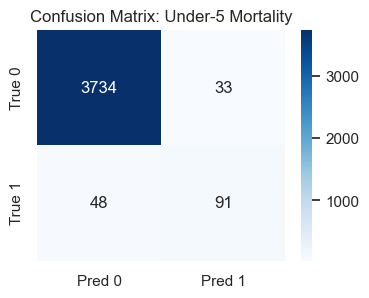

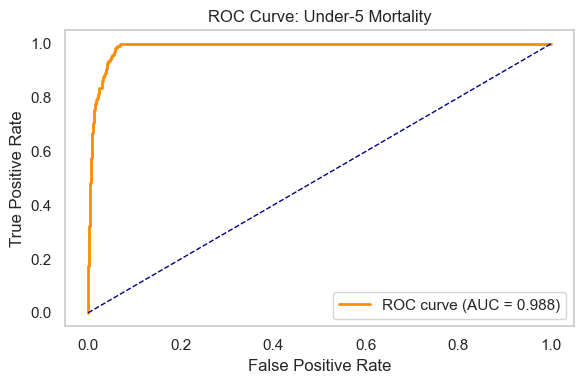

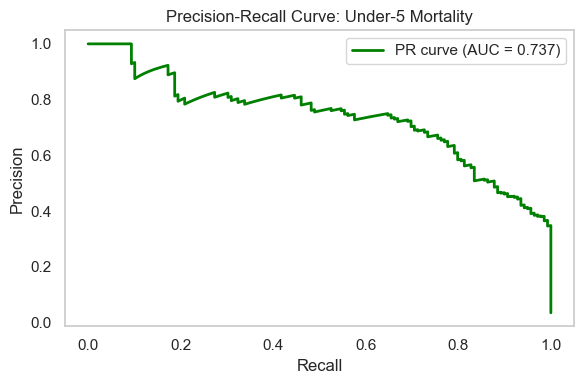


--- Baseline Logistic Regression: Infant Mortality ---
Accuracy: 0.990
              precision    recall  f1-score   support

           0      0.991     0.999     0.995      3870
           1      0.167     0.028     0.048        36

    accuracy                          0.990      3906
   macro avg      0.579     0.513     0.521      3906
weighted avg      0.983     0.990     0.986      3906

F2 Score: 0.033
ROC-AUC: 0.971
PR-AUC: 0.187


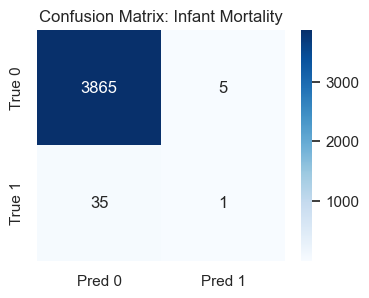

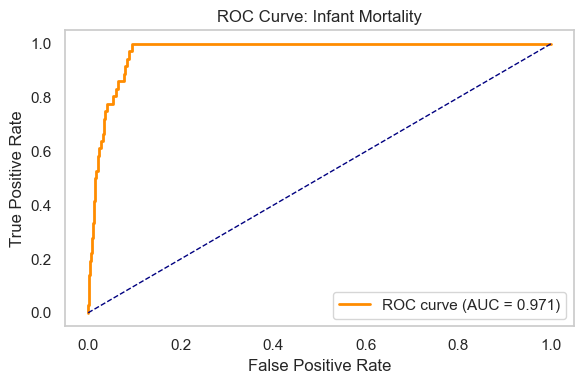

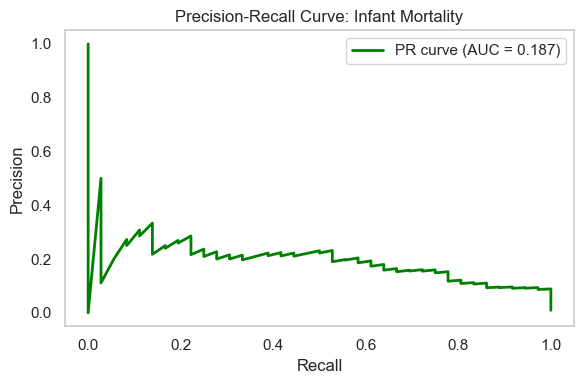


--- Baseline Logistic Regression: Neonatal Mortality ---
Accuracy: 0.984
              precision    recall  f1-score   support

           0      0.988     0.996     0.992      3819
           1      0.741     0.460     0.567        87

    accuracy                          0.984      3906
   macro avg      0.864     0.728     0.780      3906
weighted avg      0.982     0.984     0.983      3906

F2 Score: 0.498
ROC-AUC: 0.985
PR-AUC: 0.655


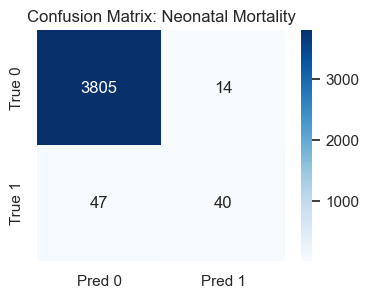

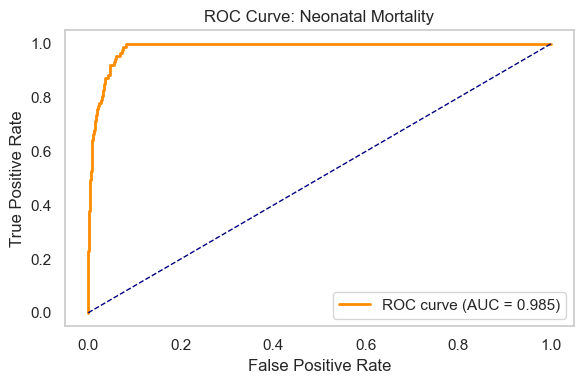

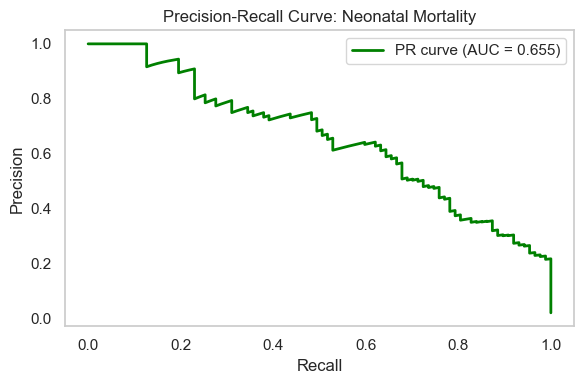

In [102]:
baseline_logistic(X, df['under5_mortality'], 'Under-5 Mortality')
baseline_logistic(X, df['infant_mortality'], 'Infant Mortality')
baseline_logistic(X, df['neonatal_mortality'], 'Neonatal Mortality')

## Logistic Regression with SMOTE

In [103]:
smote_pipe = Pipeline([
    ('preprocessor', preprocessor),      # <--- reuse the preprocessor you just built
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [104]:

def logistic_with_smote(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    smote_pipe.fit(X_train, y_train)
    y_pred = smote_pipe.predict(X_test)
    y_prob = smote_pipe.predict_proba(X_test)[:, 1]   # probabilities for ROC/PR

    print(f"\n--- Logistic Regression + SMOTE : {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("PR-AUC:", average_precision_score(y_test, y_prob))
 
    #Log results here
    log_results("LogReg + SMOTE", name, y_test, y_pred, y_prob)


In [105]:
# Run for each target
logistic_with_smote(X, df['under5_mortality'], 'Under-5 Mortality')
logistic_with_smote(X, df['infant_mortality'], 'Infant Mortality')
logistic_with_smote(X, df['neonatal_mortality'], 'Neonatal Mortality')


--- Logistic Regression + SMOTE : Under-5 Mortality ---
Accuracy: 0.9564772145417306
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3767
           1       0.45      0.94      0.61       139

    accuracy                           0.96      3906
   macro avg       0.72      0.95      0.79      3906
weighted avg       0.98      0.96      0.96      3906

F2 Score: 0.7714958775029447
ROC-AUC: 0.9881706527530829
PR-AUC: 0.6992712068292204

--- Logistic Regression + SMOTE : Infant Mortality ---
Accuracy: 0.9544290834613415
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3870
           1       0.13      0.69      0.22        36

    accuracy                           0.95      3906
   macro avg       0.56      0.83      0.60      3906
weighted avg       0.99      0.95      0.97      3906

F2 Score: 0.37202380952380953
ROC-AUC: 0.9662790697674418
PR-AUC: 0.1637038752498126

--- L

## Neural network

In [106]:
! pip install scikeras


In [107]:
## building the neural network
def build_nn(hidden_units=64, dropout=0.3, learning_rate=0.001, meta=None):
    """
    meta: scikeras passes a dict with data info
    meta['n_features_in_'] is the number of columns after preprocessing
    """
    n_features = meta["n_features_in_"]

    model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(hidden_units//2, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model


In [108]:
nn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('nn', KerasClassifier(
        model=build_nn,
        epochs=30,           # default values; will be overridden by grid search
        batch_size=32,
        verbose=0
    ))
])

In [109]:
param_grid = {
    'nn__hidden_units': [32, 64],
    'nn__dropout': [0.2, 0.3],
    'nn__learning_rate': [0.001, 0.0005],
    'nn__epochs': [20, 30],
    'nn__batch_size': [32, 64]
}


In [110]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=nn_pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

In [111]:
def train_eval_nn(X, y, target_name, pipeline=nn_pipe):
    """
    Train and evaluate the neural network pipeline on one target.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series or np.array
        Binary target column.
    target_name : str
        Name of the target for display in the report.
    pipeline : sklearn.pipeline.Pipeline
        The neural network pipeline (with preprocessing + SMOTE + KerasClassifier).
    """

    # Split data with stratification to keep class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]   # probability for class 1

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    f2  = fbeta_score(y_test, y_pred, beta=2)
    roc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    # Report
    print(f"\n==== Neural Network Results: {target_name} ====")
    print(f"Accuracy:   {acc:.3f}")
    print(f"F2 Score:   {f2:.3f}")
    print(f"ROC-AUC:    {roc:.3f}")
    print(f"PR-AUC:     {pr_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
        # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {target_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # --- Precision-Recall Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {target_name}')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Log results here
    log_results("Neural Network", target_name, y_test, y_pred, y_prob)




==== Neural Network Results: Under-5 Mortality ====
Accuracy:   0.991
F2 Score:   0.860
ROC-AUC:    0.998
PR-AUC:     0.916

Classification Report:
              precision    recall  f1-score   support

           0      0.995     0.995     0.995      3767
           1      0.875     0.856     0.865       139

    accuracy                          0.991      3906
   macro avg      0.935     0.926     0.930      3906
weighted avg      0.990     0.991     0.990      3906



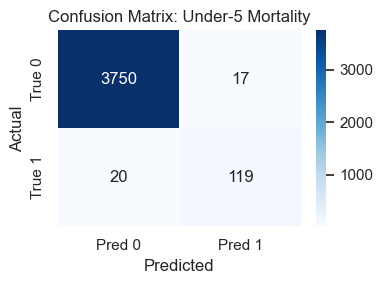

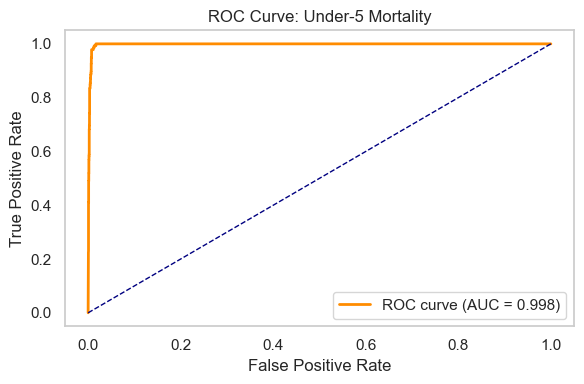

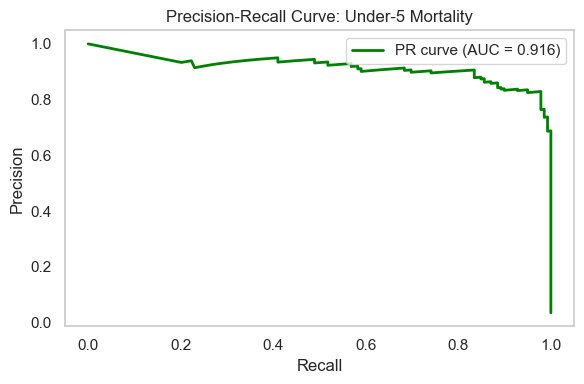


==== Neural Network Results: Infant Mortality ====
Accuracy:   0.990
F2 Score:   0.097
ROC-AUC:    0.955
PR-AUC:     0.237

Classification Report:
              precision    recall  f1-score   support

           0      0.992     0.998     0.995      3870
           1      0.273     0.083     0.128        36

    accuracy                          0.990      3906
   macro avg      0.632     0.541     0.561      3906
weighted avg      0.985     0.990     0.987      3906



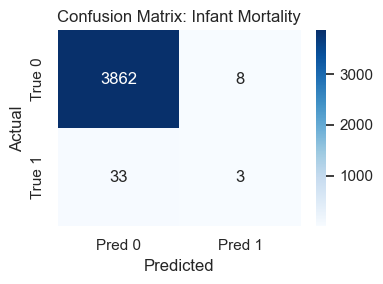

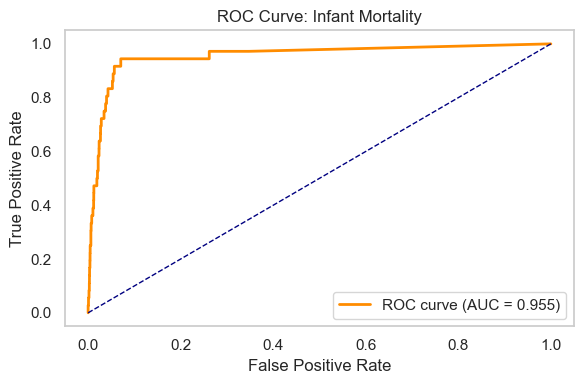

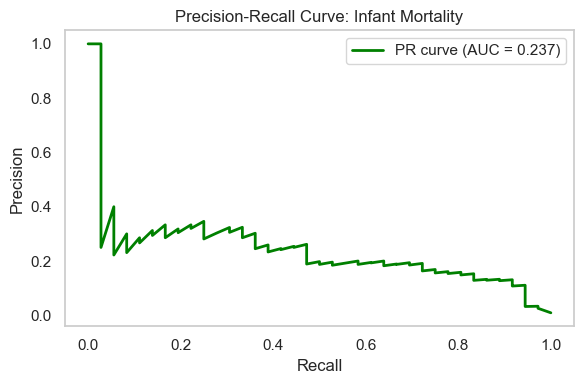


==== Neural Network Results: Neonatal Mortality ====
Accuracy:   0.984
F2 Score:   0.592
ROC-AUC:    0.992
PR-AUC:     0.708

Classification Report:
              precision    recall  f1-score   support

           0      0.990     0.994     0.992      3819
           1      0.676     0.575     0.621        87

    accuracy                          0.984      3906
   macro avg      0.833     0.784     0.807      3906
weighted avg      0.983     0.984     0.984      3906



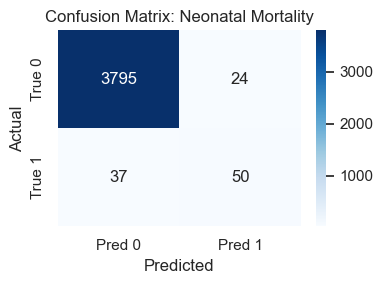

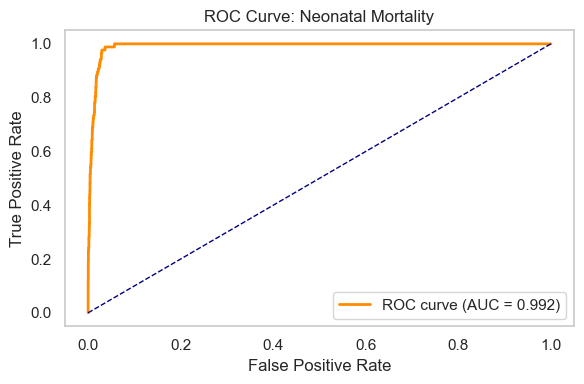

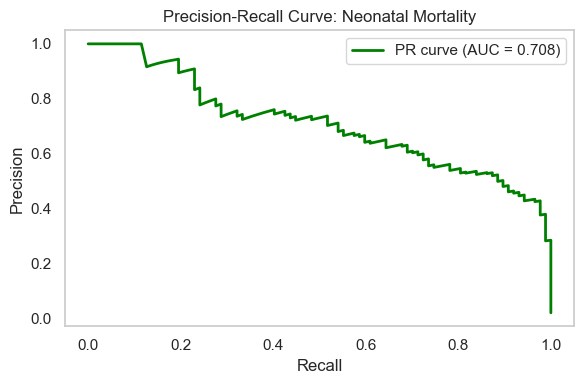

In [112]:
train_eval_nn(X, df['under5_mortality'], 'Under-5 Mortality')
train_eval_nn(X, df['infant_mortality'], 'Infant Mortality')
train_eval_nn(X, df['neonatal_mortality'], 'Neonatal Mortality')


### Neural Network + ensemble method


=== Under-5 results for === Stacking Ensemble
Accuracy: 0.995647721454173
F2 Score: 0.9675141242937854
ROC-AUC: 0.99898398244505
PR-AUC : 0.9618222788728734
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3767
           1       0.90      0.99      0.94       139

    accuracy                           1.00      3906
   macro avg       0.95      0.99      0.97      3906
weighted avg       1.00      1.00      1.00      3906



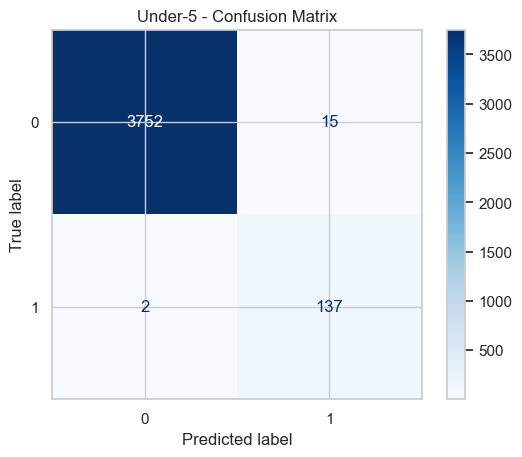

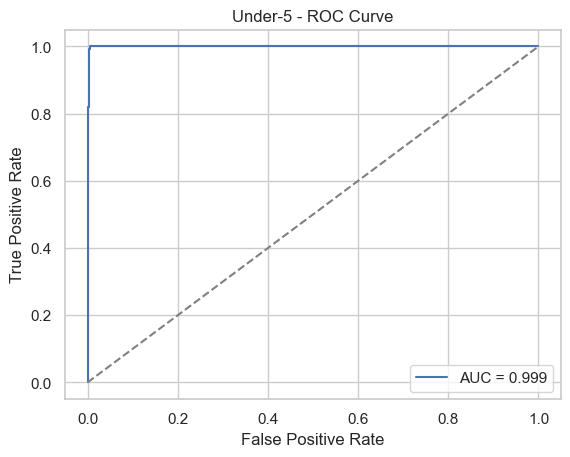

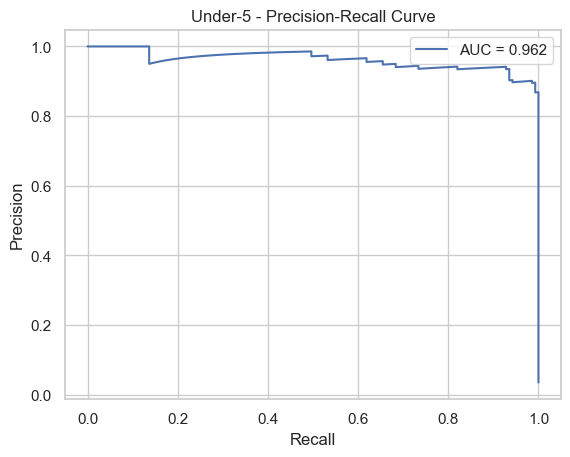


=== Infant results for === Stacking Ensemble
Accuracy: 0.9915514592933948
F2 Score: 0.19607843137254902
ROC-AUC: 0.9933175423485501
PR-AUC : 0.5144268448487034
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3870
           1       0.67      0.17      0.27        36

    accuracy                           0.99      3906
   macro avg       0.83      0.58      0.63      3906
weighted avg       0.99      0.99      0.99      3906



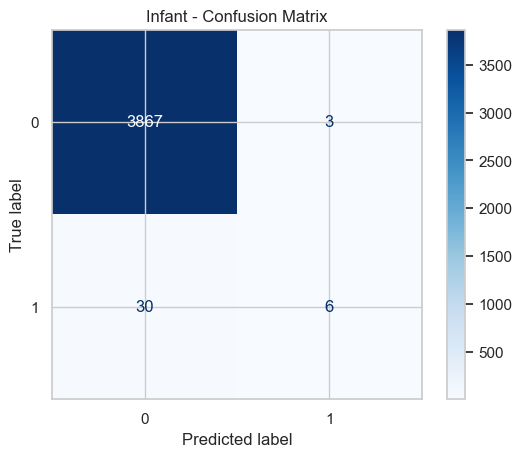

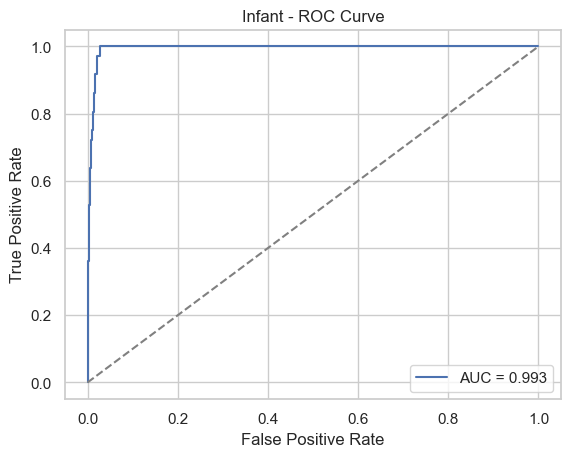

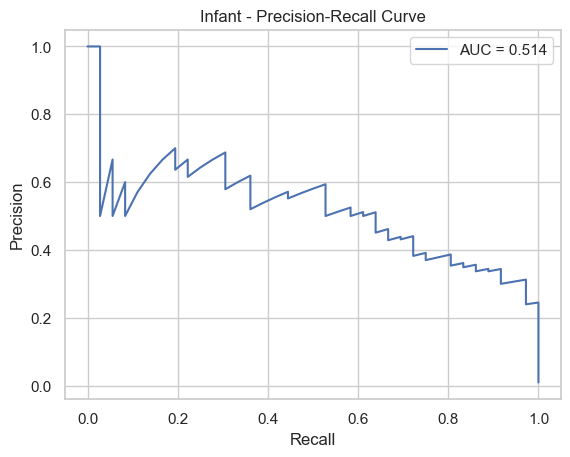


=== Neonatal results for === Stacking Ensemble
Accuracy: 0.9887352790578597
F2 Score: 0.6626506024096386
ROC-AUC: 0.9955064363602435
PR-AUC : 0.8391162086778265
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3819
           1       0.82      0.63      0.71        87

    accuracy                           0.99      3906
   macro avg       0.91      0.81      0.85      3906
weighted avg       0.99      0.99      0.99      3906



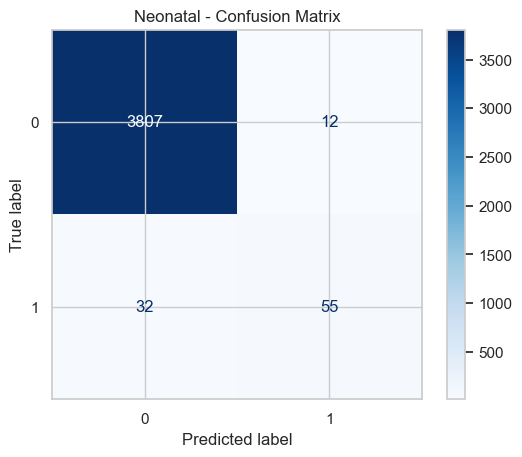

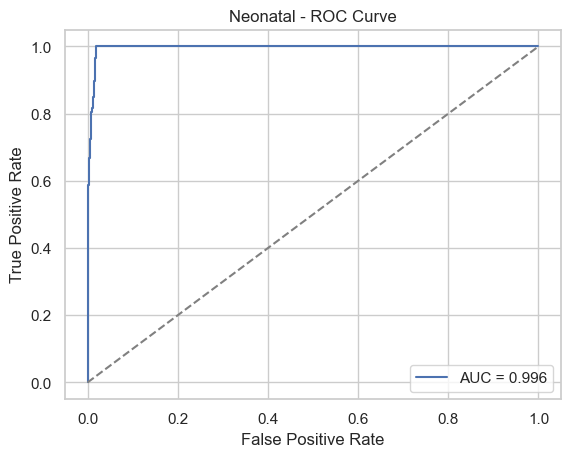

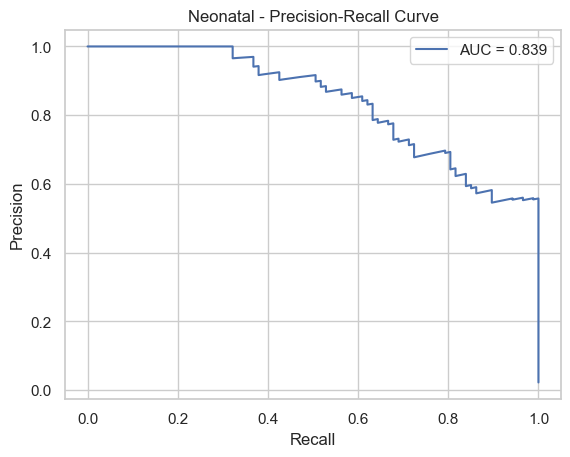

In [113]:


# ---------------------------------------------------------
# Base-model pipelines: each has its own preprocessor
# ---------------------------------------------------------
gb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    ))
])

# nn_pipe is assumed to be already defined like:
# nn_pipe = Pipeline([
#     ('preprocessor', preprocessor),
#     ('nn', KerasClassifier(...))
# ])

# ---------------------------------------------------------
# Function to build & fit the stacking ensemble
# ---------------------------------------------------------
def stacking_ensemble():
    estimators = [
        ('gb', gb_pipe),
        ('rf', rf_pipe),
        ('xgb', xgb_pipe),
        ('nn', nn_pipe)
    ]
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000),
        n_jobs=1   # changed from -1 to 1 to avoid pickling issues
    )
    return stack

# ---------------------------------------------------------
# Evaluation helper
# ---------------------------------------------------------
def evaluate_model(model, X_test, y_test, label, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"\n=== {label} results for === {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("PR-AUC :", auc(*precision_recall_curve(y_test, y_prob)[1::-1]))
    print(classification_report(y_test, y_pred))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{label} - Confusion Matrix")
    plt.show()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label} - ROC Curve")
    plt.legend()
    plt.show()

    # --- Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{label} - Precision-Recall Curve")
    plt.legend()
    plt.show()

    # Log results here
    log_results(model_name, label, y_test, y_pred, y_prob)

# ---------------------------------------------------------
# Targets to loop through
# ---------------------------------------------------------
targets = {
    'Under-5': df['under5_mortality'],
    'Infant':  df['infant_mortality'],
    'Neonatal': df['neonatal_mortality']
}

# ---------------------------------------------------------
# Train + evaluate for each target
# ---------------------------------------------------------
for name, y in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    stack = stacking_ensemble()
    stack.fit(X_train, y_train)
    evaluate_model(stack, X_test, y_test, label=name, model_name="Stacking Ensemble")


## 📊 Final Model Performance Comparison

This section compiles and compares the performance metrics across all evaluated models for each classification task:

- **Under-5 Mortality**
- **Infant Mortality**
- **Neonatal Mortality**

Each model is evaluated using the following metrics:

- **Accuracy**: Overall proportion of correct predictions.
- **F2 Score**: Weighted harmonic mean of precision and recall, placing more emphasis on recall (suitable for mortality detection).
- **ROC-AUC**: Area under the Receiver Operating Characteristic curve — reflects model’s ability to distinguish between classes.
- **PR-AUC**: Area under the Precision-Recall curve — more informative for imbalanced datasets.

The table below is:
- **Sorted by target and ROC-AUC** (descending)
- **Formatted to 3 decimal places**
- **Highlighted** to show the best-performing model for each metric using light green.

This visual summary makes it easier to identify which models perform best for each target and metric.


In [114]:
# ======= Final Model Comparison =======
results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by=["Target", "ROC-AUC"], ascending=[True, False])

results_df.style.set_caption("📊 Model Performance Comparison") \
    .format({
        "Accuracy": "{:.3f}",
        "F2 Score": "{:.3f}",
        "ROC-AUC": "{:.3f}",
        "PR-AUC": "{:.3f}"
    }) \
    .highlight_max(subset=["F2 Score", "ROC-AUC", "PR-AUC"], color="lightgreen")


,Model,Target,Accuracy,F2 Score,ROC-AUC,PR-AUC
10,Stacking Ensemble,Infant,0.992,0.196,0.993,0.514
1,Logistic Regression,Infant Mortality,0.990,0.033,0.971,0.187
4,LogReg + SMOTE,Infant Mortality,0.954,0.372,0.966,0.153
7,Neural Network,Infant Mortality,0.990,0.097,0.955,0.237
11,Stacking Ensemble,Neonatal,0.989,0.663,0.996,0.839
8,Neural Network,Neonatal Mortality,0.984,0.592,0.992,0.708
5,LogReg + SMOTE,Neonatal Mortality,0.958,0.681,0.987,0.655
2,Logistic Regression,Neonatal Mortality,0.984,0.498,0.985,0.655
9,Stacking Ensemble,Under-5,0.996,0.968,0.999,0.962
6,Neural Network,Under-5 Mortality,0.991,0.860,0.998,0.916


## Feature Importance